In [1]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should return the number of GPUs
print(torch.cuda.get_device_name(0))  # Should show the GPU model

True
1
NVIDIA RTX 5000 Ada Generation


In [3]:
import transformers
import torch
import os
import json
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM
import logging
import time
from datetime import timedelta, datetime
import pandas as pd
from dotenv import load_dotenv
import shutil 

import evaluate
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Load environment variables
load_dotenv(dotenv_path="../../.env") # path is relative to this script, adjust as needed

run_id = "LMForge_RUN03"  # <- Change this manually for each experiment
batch_size = 10  # <- Change this manually for each experiment

In [3]:
import logging
logging.basicConfig(filename='generation.log', level=logging.INFO)
logging.info(f"Run ID: {run_id}")

In [4]:
# setting huggingface token
login(token=os.getenv("HUGGINGFACE_TOKEN"))

os.environ["HF_HOME"] = "D:/huggingface_cache" 
os.environ["TRANSFORMERS_CACHE"] = "D:/huggingface_cache"
os.environ["HUGGINGFACE_HUB_CACHE"] = "D:/huggingface_cache"

print("HF_HOME:", os.getenv("HF_HOME"))
print("TRANSFORMERS_CACHE:", os.getenv("TRANSFORMERS_CACHE"))
print("HUGGINGFACE_HUB_CACHE:", os.getenv("HUGGINGFACE_HUB_CACHE"))

logging.info(f"HF_HOME: {os.getenv('HF_HOME')}")
logging.info(f"TRANSFORMERS_CACHE: {os.getenv('TRANSFORMERS_CACHE')}")
logging.info(f"HUGGINGFACE_HUB_CACHE: {os.getenv('HUGGINGFACE_HUB_CACHE')}")

transformers.utils.hub.TRANSFORMERS_CACHE = "D:/huggingface_cache"

HF_HOME: D:/huggingface_cache
TRANSFORMERS_CACHE: D:/huggingface_cache
HUGGINGFACE_HUB_CACHE: D:/huggingface_cache


In [5]:
model_name = "meta-llama/Meta-Llama-3-8B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="cuda")


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
chunk_sizes = [128, 256, 512, 1024]
questions_num = 2
max_token_list = [128,256,512,1024,2048]


In [7]:
results_df = pd.DataFrame(columns=[
    "chunk_size", "questions_num", "qa_count_mismatch", "total_questions", "token_Size",
    "total_chunks", "success_count", "fail_count",
    "elapsed_time"
])

In [8]:
def power_analysis(chunk_size, max_tokens, qa_results,substring_date,elapsed_time):
    """
    Perform power analysis based on the provided parameters for the current run.
    """
    
    # https://huggingface.co/spaces/evaluate-metric/bertscore
    # https://huggingface.co/tasks/sentence-similarity
    # 1 Metric: ROUGE
    rouge = evaluate.load("rouge")

    originals = []
    generations = []

    for doc in qa_results.values():
        for item in doc:
            chunk = item.get("chunk")
            qa_pairs = item.get("qa_pairs", [])
            if not chunk or not isinstance(qa_pairs, list):
                continue  # Skip if chunk is missing or qa_pairs is not a list
            for pair in qa_pairs:
                answer = pair.get("answer") if isinstance(pair, dict) else None
                if answer:  # Only add if answer exists and is not None/empty
                    originals.append(str(chunk))
                    generations.append(str(answer))


    scores = rouge.compute(predictions=generations, references=originals)
    print(f"ROUGE Scores: {scores}")
    logging.info(f"ROUGE Scores: {scores} for chunk_size {chunk_size}, max_tokens {max_tokens}, questions_num {questions_num}")

    # 2 Metric: BERTScore
    bertscore = evaluate.load("bertscore")
    bert_scores = bertscore.compute(predictions=generations, references=originals, model_type="bert-base-uncased", lang="en")
    P = bert_scores["precision"]
    R = bert_scores["recall"]
    F1 = bert_scores["f1"] 

    print(f"BERTScore: {bert_scores}")
    logging.info(f"BERTScore: {bert_scores} for chunk_size {chunk_size}, max_tokens {max_tokens}, questions_num {questions_num}")

    # 3 Metric: STS (Semantic Textual Similarity)
    sts_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    original_embeddings = sts_model.encode(originals, convert_to_tensor=True) 
    generated_embeddings = sts_model.encode(generations, convert_to_tensor=True)
    sts_scores = util.pytorch_cos_sim(original_embeddings, generated_embeddings).diagonal().cpu().tolist()

    print(f"STS Scores: {sts_scores}")
    logging.info(f"STS Scores: {sts_scores} for chunk_size {chunk_size}, max_tokens {max_tokens}, questions_num {questions_num}")

    # save the scores to a CSV file
    scores_df = pd.DataFrame({
        "chunk_size": [chunk_size],
        "max_tokens": [max_tokens],
        "questions_num": [questions_num],
        "rouge1": [scores["rouge1"]],
        "rouge2": [scores["rouge2"]],
        "rougeL": [scores["rougeL"]],
        "rougeLsum": [scores["rougeLsum"]],
        "bert_score_P": [np.mean(P)],
        "bert_score_R": [np.mean(R)],
        "bert_score_F1": [np.mean(F1)],
        "sts_score": [np.mean(sts_scores)],
        "substring_date": [substring_date],
        "elapsed_time": [elapsed_time],
    })
    
    print("Scores saved to scores.csv")   
    logging.info(f"Scores saved to scores.csv for chunk_size {chunk_size}, max_tokens {max_tokens}, questions_num {questions_num}")
    return scores_df

# Convert logs to Panda


In [9]:
def build_prompt(chunk, questions_num):
    return f"""
Generate {questions_num} question-answer pairs based on the following text segment. 
Return the result in valid JSON format as a list of objects.

Text Segment:

{chunk}

Response Format:
[
    {{"question": "generated question", "answer": "generated Answer"}},
]

Question answers should be at least 250 words long.

Do NOT include any explanation or preamble before or after the JSON output.
Return ONLY valid JSON output.

Answer:
    """

In [10]:
def load_data(chunk_size):
    path = f"../Yaman/Generate_Paragraphs/Results/extracted_chunks_{chunk_size}_overlap.json"
    if not os.path.exists(path):
        print(f"Missing input file: {path}, skipping.")
        logging.info(f"Missing input file: {path}, skipping.")
        return None
    with open(path, "r", encoding="utf-8") as file:
        return json.load(file)

In [11]:
def update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, key, value):
    if os.path.exists(detailed_tracker_path):
        detailed_tracker_df = pd.read_csv(detailed_tracker_path)
    else:
        detailed_tracker_df = pd.DataFrame(columns=["chunk_size", "questions_num", "qa_count_mismatch", "total_questions", 
            "max_tokens", "total_chunks", "success_count", "fail_count", "repeat_count", "duplicate_count", "elapsed_time"])
    # Check if the row already exists
    row_match = (
        (detailed_tracker_df["chunk_size"] == chunk_size) &
        (detailed_tracker_df["max_tokens"] == max_tokens) 
    )
    if not detailed_tracker_df.loc[row_match].empty:
        # Update the existing row
        detailed_tracker_df.loc[row_match, key] = value
    else:
        # Add a new row
        new_row = {
            "chunk_size": chunk_size,
            "max_tokens": max_tokens,
            "questions_num": 0,
            "qa_count_mismatch": 0,
            "total_questions": 0,
            "total_chunks": 0,
            "success_count": 0,
            "fail_count": 0,
            "repeat_count": 0,
            "duplicate_count": 0,
            "elapsed_time": 0
        }
        new_row[key] = value
        # Append the new row to the DataFrame
        detailed_tracker_df = pd.concat([detailed_tracker_df, pd.DataFrame([new_row])], ignore_index=True)
        
    # Save the updated DataFrame to CSV
    detailed_tracker_df.to_csv(detailed_tracker_path, index=False)
    print(f"Updated detailed tracker: {detailed_tracker_path}")
    logging.info(f"Updated detailed tracker: {detailed_tracker_path}")

In [12]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# check if base directory exists, if not create it
if not os.path.exists(run_id):
    os.makedirs(run_id)
# Constants
check_point_path = f"{run_id}/qa_run_tracker.csv"
output_base = f"{run_id}/Generated_Results/LLAMA3_1"
detailed_tracker_path = f"{run_id}/qa_run_tracker_detailed.csv"

# Initialize tracker CSV if not present
if not os.path.exists(check_point_path):
    tracker_df = pd.DataFrame(columns=["chunk_size", "max_tokens", "questions_num", "completed"])
    for chunk_size in chunk_sizes:
        for max_tokens in max_token_list:
            tracker_df.loc[len(tracker_df)] = [chunk_size, max_tokens, questions_num, False]
    tracker_df.to_csv(check_point_path, index=False)
else:
    tracker_df = pd.read_csv(check_point_path)
    

# Results summary
results_df = pd.DataFrame(columns=[
    "chunk_size", "questions_num", "qa_count_mismatch", "total_questions",
    "max_tokens", "total_chunks", "success_count", "fail_count", "repeat_count",
    "duplicate_count", "elapsed_time"
])

# Check if detailed tracker exists, if not create it
if not os.path.exists(detailed_tracker_path):
    detailed_tracker_df = pd.DataFrame(columns=["chunk_size", "questions_num", "qa_count_mismatch", "total_questions", 
        "max_tokens", "total_chunks", "success_count", "fail_count", "repeat_count", "duplicate_count", "elapsed_time"])
    detailed_tracker_df.to_csv(detailed_tracker_path, index=False)
else:
    detailed_tracker_df = pd.read_csv(detailed_tracker_path)

for chunk_size in chunk_sizes:
    chunk_data = load_data(chunk_size)

    for max_tokens in max_token_list:
        row_match = (
            (tracker_df["chunk_size"] == chunk_size) &
            (tracker_df["max_tokens"] == max_tokens) &
            (tracker_df["questions_num"] == questions_num)
        )

        if tracker_df.loc[row_match, "completed"].any():
            print(f"Skipping chunk_size={chunk_size}, max_tokens={max_tokens} (already completed)")
            logging.info(f"Skipping chunk_size={chunk_size}, max_tokens={max_tokens} (already completed)")
            continue
        print(f"Processing chunk_size={chunk_size}, max_tokens={max_tokens}")
        logging.info(f"Processing chunk_size={chunk_size}, max_tokens={max_tokens}")

        output_file_path = f"{output_base}/generation_log_{chunk_size}_Token_{max_tokens}_Q{questions_num}.json"

        # Load existing results if file exists
        if os.path.exists(output_file_path):
            try:
                with open(output_file_path, "r", encoding="utf-8") as f:
                    qa_results = json.load(f)
            except json.JSONDecodeError:
                print("Warning: Output file is corrupted. Starting fresh.")
                logging.info("Warning: Output file is corrupted. Starting fresh.")
                qa_results = {}
        else:
            # Create the output directory if it doesn't exist
            os.makedirs(os.path.dirname(output_file_path), exist_ok=True)
            qa_results = {}

        # Trackers
        total_chunks = 0
        success_count = 0
        fail_count = 0
        total_questions = 0
        qa_count_mismatch = 0
        repeat_count = 0
        duplicate_count = 0
        chunk_counter = 0

        start_time = time.time()

        for doc_name, chunks in chunk_data.items():
            if doc_name in qa_results and qa_results[doc_name]:
                print(f"Skipping {doc_name} (already processed)")
                logging.info(f"Skipping {doc_name} (already processed)")
                continue
            print(f"Processing {doc_name}...")
            logging.info(f"Processing {doc_name}...")
            # Initialize the document in the results dictionary
            qa_results[doc_name] = []

            for chunk in chunks[:1000]:  # Adjust slice as needed
                total_chunks += 1
                update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, "total_chunks", total_chunks)
                chunk_counter += 1
                prompt = build_prompt(chunk, questions_num)
                try:
                    inputs = tokenizer(prompt, return_tensors="pt").to(device)
                    with torch.no_grad():
                        output_tokens = model.generate(**inputs, max_new_tokens=max_tokens,pad_token_id=tokenizer.eos_token_id)
                    generated_tokens = output_tokens[0][len(inputs["input_ids"][0]):]
                    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
                    qa_pairs = json.loads(generated_text)

                    if isinstance(qa_pairs, list):
                        qa_results[doc_name].append({
                            "chunk": chunk,
                            "qa_pairs": qa_pairs
                        })
                        success_count += 1
                        update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, "success_count", success_count)
                        total_questions += len(qa_pairs)
                        update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, "total_questions", total_questions)

                        if len(qa_pairs) != questions_num:
                            qa_count_mismatch += 1
                            update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, "qa_count_mismatch", qa_count_mismatch)
                            logging.info(f"Warning: Expected {questions_num} questions, got {len(qa_pairs)}")
                        
                        #  question and answer are the same
                        for pair in qa_pairs:
                            if pair["question"] == pair["answer"]:
                                repeat_count += 1
                                update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, "repeat_count", repeat_count)
                                logging.info(f"Warning: Question and answer are the same in {doc_name}")
                            # check for duplicates in the same chunk
                            if any(pair["question"] == p["question"] for p in qa_pairs if p != pair):
                                duplicate_count += 1
                                update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, "duplicate_count", duplicate_count)
                                logging.info(f"Warning: Duplicate question in {doc_name}")
                    else:
                        fail_count += 1
                        update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, "fail_count", fail_count)
                        logging.info(f"Warning: Invalid JSON format in {doc_name}: {generated_text}")

                except Exception as e:
                    print(f"Error processing chunk from {doc_name}: {e}")
                    logging.error(f"Error processing chunk from {doc_name}: {e}")
                    fail_count += 1
                    update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, "fail_count", fail_count)
                    continue

                # Save every batch_size chunks
                if chunk_counter % batch_size == 0:
                    with open(output_file_path, "w", encoding="utf-8") as out_file:
                        json.dump(qa_results, out_file, indent=4, ensure_ascii=False)
                    print(f"Checkpoint saved at chunk {chunk_counter}")
                    logging.info(f"Checkpoint saved at chunk {chunk_counter}")

                    # update the detailed tracker
                    

            # Save after each document
            with open(output_file_path, "w", encoding="utf-8") as out_file:
                json.dump(qa_results, out_file, indent=4, ensure_ascii=False)
            print(f"Saved full doc: {doc_name}")
            logging.info(f"Saved full doc: {doc_name}")

        # Final save
        end_time = time.time()
        elapsed_time = timedelta(seconds=end_time - start_time)

        results_df.loc[len(results_df)] = [
            chunk_size, questions_num, qa_count_mismatch, total_questions,
            max_tokens, total_chunks, success_count, fail_count, repeat_count,
            duplicate_count, str(elapsed_time)
        ]

        print(f"Completed {chunk_size}, {max_tokens} | Time: {elapsed_time}")
        logging.info(f"Completed {chunk_size}, {max_tokens} | Time: {elapsed_time}")

        # Update tracker
        tracker_df.loc[row_match, "completed"] = True
        tracker_df.to_csv(check_point_path, index=False)

        scores_df = power_analysis(chunk_size, max_tokens, qa_results,run_id,elapsed_time)
        if os.path.exists(f"{output_base}/scores.csv"):
            scores_df.to_csv(f"{output_base}/scores.csv", mode='a', header=False, index=False)
        else:
            os.makedirs(f"{output_base}/scores", exist_ok=True)
            scores_df.to_csv(f"{output_base}/scores.csv", index=False)
        # save the results to a CSV file
        if os.path.exists(f"{output_base}/qa_generation_results.csv"):
            results_df.to_csv(f"{output_base}/qa_generation_results.csv", mode='a', header=False, index=False)
        else:
            os.makedirs(f"{output_base}/qa_generation_results", exist_ok=True)
            results_df.to_csv(f"{output_base}/qa_generation_results.csv", index=False)
        print(f"Results saved to {output_base}/qa_generation_results.csv")
        logging.info(f"Results saved to {output_base}/qa_generation_results.csv")


# Save summary CSV
csv_output_path = f"{output_base}/qa_generation_results_summary.csv"
results_df.to_csv(csv_output_path, index=False)
print(f"\nSummary saved to {csv_output_path}")
logging.info(f"\nSummary saved to {csv_output_path}")


Skipping chunk_size=128, max_tokens=128 (already completed)
Skipping chunk_size=128, max_tokens=256 (already completed)
Skipping chunk_size=128, max_tokens=512 (already completed)
Skipping chunk_size=128, max_tokens=1024 (already completed)
Skipping chunk_size=128, max_tokens=2048 (already completed)
Skipping chunk_size=256, max_tokens=128 (already completed)
Skipping chunk_size=256, max_tokens=256 (already completed)
Skipping chunk_size=256, max_tokens=512 (already completed)
Skipping chunk_size=256, max_tokens=1024 (already completed)
Skipping chunk_size=256, max_tokens=2048 (already completed)
Skipping chunk_size=512, max_tokens=128 (already completed)
Skipping chunk_size=512, max_tokens=256 (already completed)
Skipping chunk_size=512, max_tokens=512 (already completed)
Skipping chunk_size=512, max_tokens=1024 (already completed)
Skipping chunk_size=512, max_tokens=2048 (already completed)
Skipping chunk_size=1024, max_tokens=128 (already completed)
Skipping chunk_size=1024, max_tok

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

STS Scores: [0.5377973318099976, 0.5377973318099976, 0.5986000895500183, 0.3413649797439575, 0.3224129378795624, 0.3305491507053375, 0.4148483872413635, 0.3411356806755066, 0.49785497784614563, 0.4816817343235016, 0.5498254299163818, 0.5498254299163818, 0.5283840298652649, 0.5283840298652649, 0.7509860396385193, 0.6418629884719849, 0.491781085729599, 0.2583715319633484, 0.3760533332824707, 0.40695711970329285, 0.3621329665184021, 0.6220723390579224, -0.05335288122296333, -0.05335288122296333, 0.6933931112289429, 0.6933931112289429, 0.7421247959136963, 0.6064988374710083, 0.8460263013839722, 0.4146411716938019, 0.6594353318214417, 0.43073219060897827, 0.3849537968635559, 0.4595673084259033, 0.5084625482559204, 0.1783357411623001, 0.2817024886608124, 0.48070037364959717, 0.1733931452035904, 0.8029616475105286, 0.5360808372497559, 0.37111765146255493, 0.28644123673439026, 0.9403243064880371, 0.786180853843689, 0.5088645219802856, 0.5088645219802856, 0.13938221335411072, 0.3742692768573761

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

STS Scores: [0.42606207728385925, 0.3064024746417999, 0.26452893018722534, 0.4260966181755066, 0.3755853474140167, 0.3755853474140167, 0.5323716402053833, 0.3937053680419922, 0.4434821605682373, 0.5059823989868164, 0.7612454295158386, 0.5551158785820007, 0.5845404863357544, 0.5390400886535645, 0.5951293706893921, 0.5542025566101074, 0.1550750732421875, 0.3456736207008362, 0.42830508947372437, 0.11703664064407349, 0.23660939931869507, 0.5840656757354736, 0.26765191555023193, 0.7471975088119507, 0.7471975088119507, 0.47440028190612793, 0.6312393546104431, -0.058093465864658356, 0.11817027628421783, 0.634899377822876, 0.634899377822876, 0.9552346467971802, 0.32230472564697266, 0.6025861501693726, 0.5824428796768188, 0.6386145353317261, 0.680090069770813, 0.6500558257102966, 0.5887318849563599, 0.5955384969711304, 0.4754994213581085, 0.2680935263633728, 0.3578285574913025, 0.3475741744041443, 0.6761331558227539, 0.1799311488866806, 0.48007723689079285, 0.40788906812667847, 0.22791749238967

In [4]:
import shutil
import os
import json
def load_data(chunk_size):
    path = f"../Yaman/Generate_Paragraphs/Results/extracted_chunks_{chunk_size}_overlap.json"
    if not os.path.exists(path):
        print(f"Missing input file: {path}, skipping.")
        return None
    with open(path, "r", encoding="utf-8") as file:
        return json.load(file)
    

chunk_sizes = [128, 256, 512, 1024]
# check how many chunks are in the file for each chunk size

for chunk_size in chunk_sizes:
    chunk_data = load_data(chunk_size)
    if chunk_data is not None:
        total_chunks = sum(len(chunks) for chunks in chunk_data.values())
        print(f"Total chunks for chunk size {chunk_size}: {total_chunks}")
    else:
        print(f"No data found for chunk size {chunk_size}")

Total chunks for chunk size 128: 6996
Total chunks for chunk size 256: 3618
Total chunks for chunk size 512: 1824
Total chunks for chunk size 1024: 910


In [ ]:
# Load the CSV files
output_base = "LMForge_RUN02/Generated_Results/LLAMA3_1"
csv_files = [
    f"{output_base}/qa_generation_results.csv",
    f"{output_base}/scores.csv"
]
# Check if the files exist
for csv_file in csv_files:
    if os.path.exists(csv_file):
        print(f"File {csv_file} exists.")
    else:
        print(f"File {csv_file} does not exist. Please check the path.")
        continue
# Read the CSV files
qa_results_df = pd.read_csv(f"{output_base}/qa_generation_results.csv")
scores_df = pd.read_csv(f"{output_base}/scores.csv")
# merge the two dataframes
scores_df = pd.merge(qa_results_df, scores_df, on=["chunk_size", "max_tokens","questions_num"], how="outer")

# check for duplicates
duplicates = scores_df[scores_df.duplicated(subset=["chunk_size", "max_tokens","questions_num"], keep=False)]
if not duplicates.empty:
    print("Duplicates found:")
    print(duplicates)
else:
    print("No duplicates found.")

# drop duplicates
scores_df = scores_df.drop_duplicates(subset=["chunk_size", "max_tokens","questions_num"], keep="first")
# list of columns to drop
columns_to_drop = ["qa_count_mismatch", "total_questions", "success_count", "fail_count", "repeat_count", "duplicate_count", "elapsed_time"]
scores_df = scores_df.drop(columns=[col for col in columns_to_drop if col in scores_df.columns])

File LMForge_RUN02/Generated_Results/LLAMA3_1/qa_generation_results.csv exists.
File LMForge_RUN02/Generated_Results/LLAMA3_1/scores.csv exists.
No duplicates found.


## Statistical Significance

#### MANOVA ASSUMPTIONS
- Multivariate Normality dependent variables should be jointly normally distributed
- Homogeneity of variance-covariance matrices
- Independence of observations
- No multicollinearity
- Linearity
- Outliers

In [ ]:
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

dv_columns = [
    "rouge1", "rouge2", "rougeL", "rougeLsum",
    "bert_score_P", "bert_score_R", "bert_score_F1",
    "sts_score"
]
# Select only the dependent variables (DVs)
X = scores_df[dv_columns].dropna()

# Standardize DVs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute robust Mahalanobis distances
robust_cov = MinCovDet().fit(X_scaled)
mahalanobis_distances = robust_cov.mahalanobis(X_scaled)

# Convert to p-values assuming chi-square distribution
p_values = 1 - chi2.cdf(mahalanobis_distances, df=X.shape[1])

# Estimate what % of observations are likely normal
normality_pass_rate = np.mean(p_values > 0.05)

print(f"Normality pass rate: {normality_pass_rate:.2%}")
# Save the updated DataFrame to CSV
scores_df.to_csv(f"{output_base}/significance_qa_generation_results.csv", index=False)


Normality pass rate: 75.00%


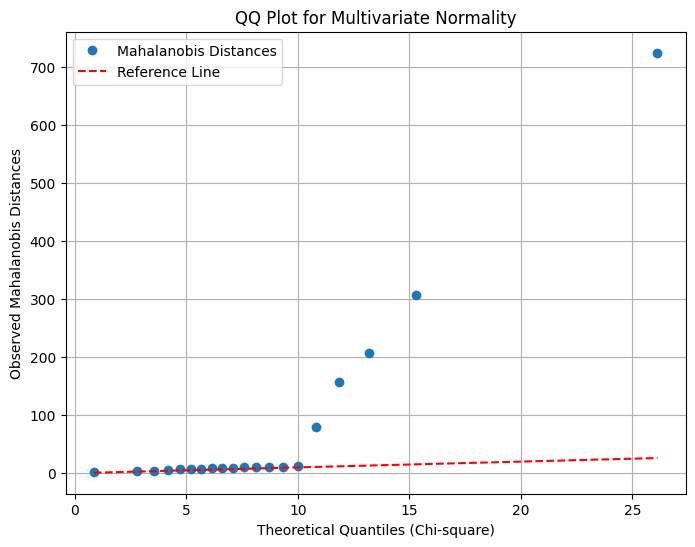

In [ ]:
# Generate theoretical chi-square quantiles for comparison
sorted_md = np.sort(mahalanobis_distances)
quantiles = stats.chi2.ppf(np.linspace(0.001, 0.999, len(sorted_md)), df=X_scaled.shape[1])

# QQ Plot
plt.figure(figsize=(8, 6))
plt.plot(quantiles, sorted_md, marker='o', linestyle='', label='Mahalanobis Distances')
plt.plot(quantiles, quantiles, color='red', linestyle='--', label='Reference Line')
plt.xlabel("Theoretical Quantiles (Chi-square)")
plt.ylabel("Observed Mahalanobis Distances")
plt.title("QQ Plot for Multivariate Normality")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
 ## homogeneity of covariance matrices could not be formally tested.

In [ ]:
threshold = chi2.ppf(0.999, df=X_scaled.shape[1])  # 99.9% cutoff
outlier_flags = mahalanobis_distances > threshold
num_outliers = np.sum(outlier_flags)

# summary of outlier results
outlier_summary = pd.DataFrame([{
    "Total Observations": len(mahalanobis_distances),
    "Outliers Detected (p < 0.001)": num_outliers,
    "Percentage Outliers": 100 * num_outliers / len(mahalanobis_distances)
}])
print(outlier_summary)

   Total Observations  Outliers Detected (p < 0.001)  Percentage Outliers
0                  20                              5                 25.0


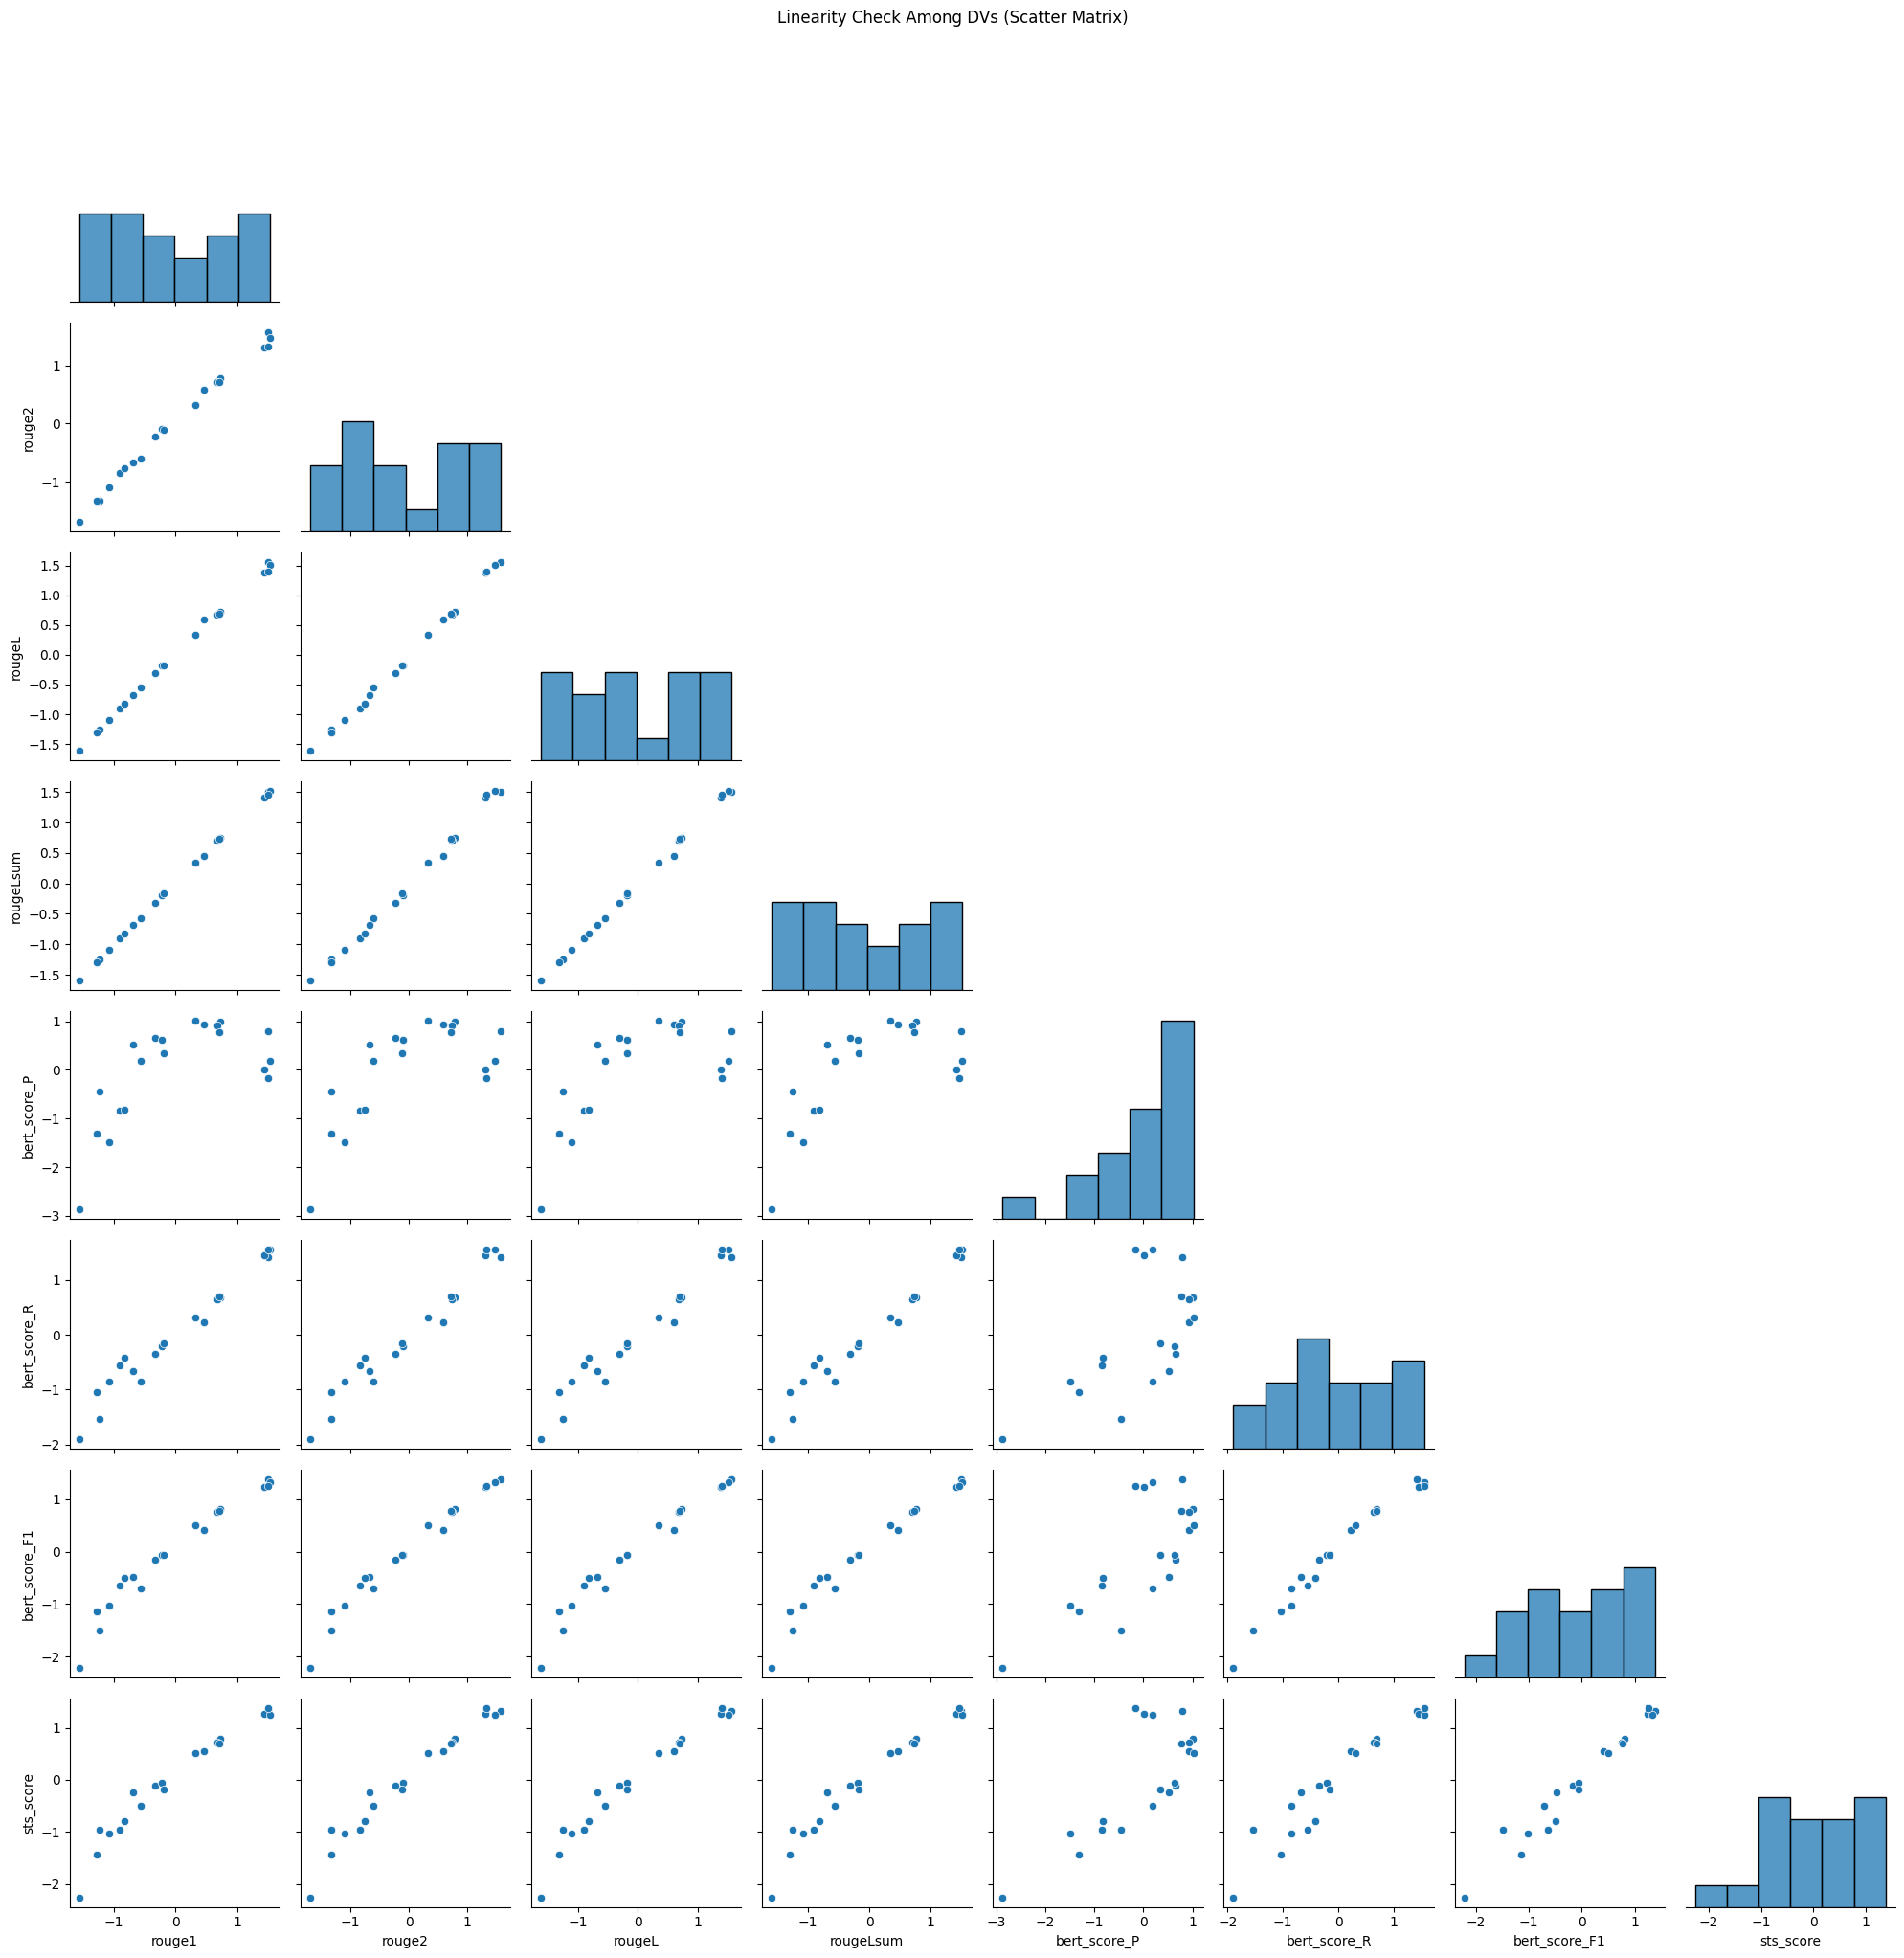

In [ ]:
import seaborn as sns
# Create DataFrame for scaled data
scaled_df = pd.DataFrame(X_scaled, columns=dv_columns)

# Generate a scatter matrix (pairplot)
sns.pairplot(scaled_df, corner=True)
plt.suptitle("Linearity Check Among DVs (Scatter Matrix)", y=1.02)
plt.tight_layout()
plt.show()